# Data : read & prepare

In [10]:
train <- read.csv2('TrainSample.csv')

In [11]:
nums <- sapply(train, is.numeric)
gasPred <- train[ , nums]
gasPred$API <- NULL

oilPred <- gasPred

gasPred$OilCum360 <- NULL
oilPred$GasCum360 <- NULL

# Linear regression

In [13]:
gasModel <- lm(GasCum360 ~ ., gasPred)
summary(gasModel)


Call:
lm(formula = GasCum360 ~ ., data = gasPred)

Residuals:
   Min     1Q Median     3Q    Max 
-50447 -13633  -2456  11484  78781 

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)    
(Intercept)                   60820.9     2728.7  22.289  < 2e-16 ***
Surf_X                       -44851.9    21784.6  -2.059  0.04045 *  
Surf_Y                       -41236.3    31282.7  -1.318  0.18855    
Lateral_Length..ft.           28696.4     5497.5   5.220 3.55e-07 ***
Depth_TVD_PPLS..ft.          -28869.4    20105.0  -1.436  0.15217    
Erosion_PPLS..ft.             -1534.2     2827.2  -0.543  0.58781    
Pressure_PPLS..PSI.            -992.1     3123.0  -0.318  0.75096    
TOC_PPLS....                 -18480.2     4219.3  -4.380 1.69e-05 ***
Vcarb_PPLS                   -33401.8    14728.4  -2.268  0.02412 *  
Vsand_PPLS                    -7473.7    10104.0  -0.740  0.46013    
Vclay_PPLS                    -9429.2     8304.4  -1.135  0.25718    
PR_PPLS   

In [19]:
oilModel <- lm(OilCum360 ~ ., oilPred)
summary(oilModel)


Call:
lm(formula = OilCum360 ~ ., data = oilPred)

Residuals:
    Min      1Q  Median      3Q     Max 
-1797.5  -293.8    -2.7   277.8  4125.0 

Coefficients:
                              Estimate Std. Error t value Pr(>|t|)    
(Intercept)                   1321.122     87.919  15.027  < 2e-16 ***
Surf_X                          19.031    701.899   0.027  0.97839    
Surf_Y                         900.107   1007.930   0.893  0.37263    
Lateral_Length..ft.           -576.848    177.129  -3.257  0.00127 ** 
Depth_TVD_PPLS..ft.            731.822    647.784   1.130  0.25958    
Erosion_PPLS..ft.               47.388     91.092   0.520  0.60333    
Pressure_PPLS..PSI.            -78.414    100.622  -0.779  0.43648    
TOC_PPLS....                   584.976    135.946   4.303 2.35e-05 ***
Vcarb_PPLS                    1016.446    474.549   2.142  0.03308 *  
Vsand_PPLS                     505.079    325.550   1.551  0.12195    
Vclay_PPLS                     370.684    267.568   1.385  

# Results


## Gas

Warning message:
In predict.lm(gasModel, interval = "pred") :
  predictions on current data refer to _future_ responses



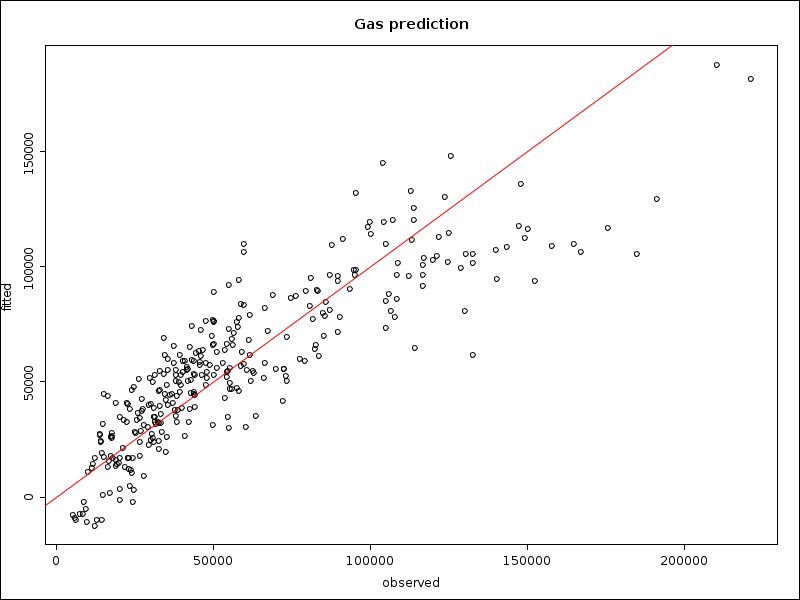

In [36]:
gasPredicted <- predict(gasModel, interval = "pred")
plot(gasModel$model[,1], gasPredicted[,1], ylab = "fitted", xlab = "observed",
    main = "Gas prediction")
abline(a=0, b=1, col =2)

## Oil

Warning message:
In predict.lm(oilModel, interval = "pred") :
  predictions on current data refer to _future_ responses



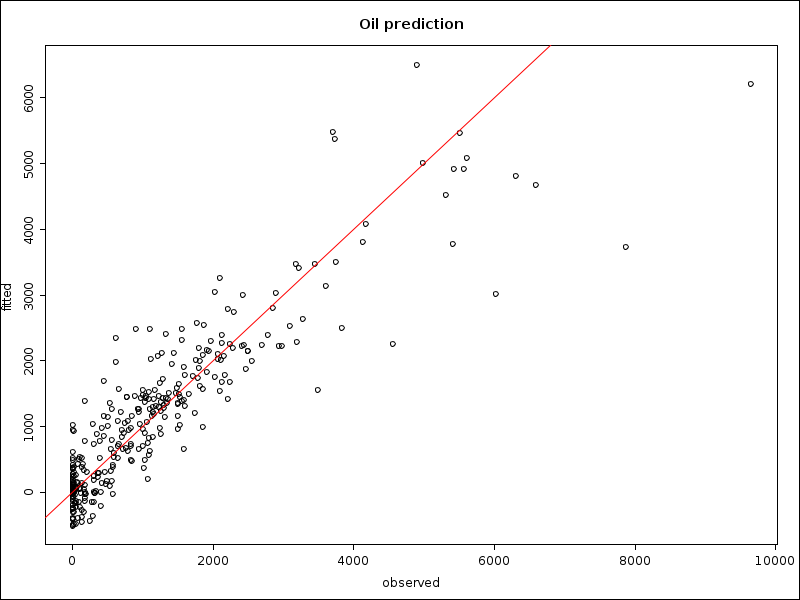

In [37]:
oilPredicted <- predict(oilModel, interval = "pred")
plot(oilModel$model[,1], oilPredicted[,1], ylab = "fitted", xlab = "observed",
    main = "Oil prediction")
abline(a=0, b=1, col =2)

## Cross-validation example (gas)

In [46]:
library(DiceEval)

Y <- gasModel$model[,1]
X <- data.frame(gasModel$model[,2:ncol(gasModel$model)])
colnames(X) <- c(paste( "X", c(1:ncol(X)), sep=""))
formula <- as.formula(paste("Y~", paste (paste("X", c(1:ncol(X)), sep=""),
                                         collapse="+"),sep=""))


model.CV <- modelFit(X,Y, type = "Linear", formula = formula)

## Nombre de groupes :
K <- 3

## Validation croisée :
CV <- crossValidation(model.CV ,K=K)

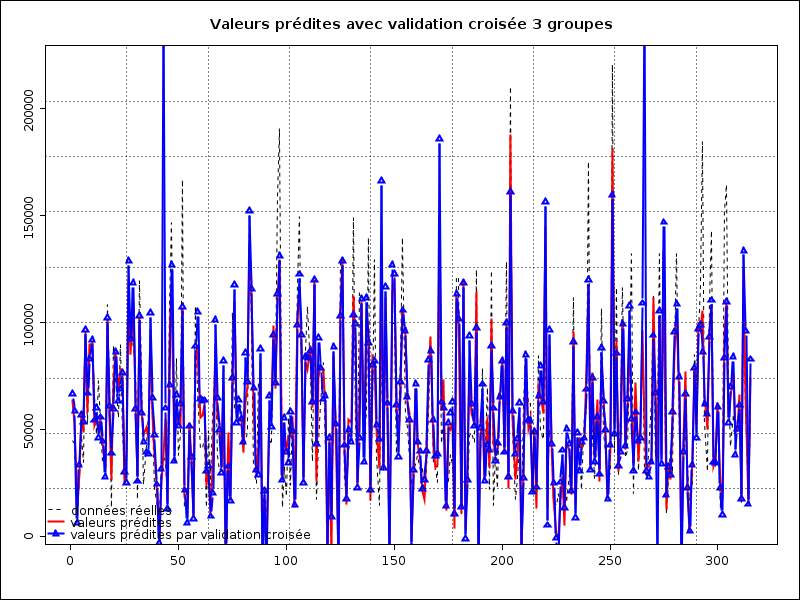

In [48]:
# plot

plot(as.ts(Y), lty = 2, xlab = "", ylab = "", 
     main = paste("Valeurs prédites avec validation croisée ",K," groupes",sep=""))
lines(as.ts(model.CV$model$fitted.values), lwd = 2, col = 'red')
lines(as.ts(CV$Ypred), type = 'b', lwd = 2, pch = 2, col = 'blue')
box()
grid(9,lwd=1, col="1")
legend("bottomleft",
       c("données réelles", "valeurs prédites", "valeurs prédites par validation croisée"),
       lwd = c(1,2,2), lty = c(2,1,1), pch = c(NA,NA,2), col = c('black', 'red', 'blue'),
       cex = 1, bty="n")

# Prediction

In [76]:
test <- read.csv2('TestSample.csv')
test[is.na(test)] <- 0

In [81]:
testGas <- predict(gasModel, newdata = test, interval = 'confidence')
testOil <- predict(oilModel, newdata = test, interval = 'confidence')

In [82]:
results <- data.frame(ID = test$API,
                      CUM360_INF = testOil[,2],
                      CUM360_SUP = testOil[,3],
                      GAS360_INF = testGas[,2],
                      GAS360_SUP = testGas[,3])

In [83]:
head(results)

   ID CUM360_INF CUM360_SUP GAS360_INF GAS360_SUP
1 633  1224.2331  2114.7095  22227.783   49865.18
2 587  -873.1864   260.8858  66771.182  101968.97
3 264   649.7896  1423.2936  83524.264  107531.23
4 680  -435.4351   453.3454  85943.204  113527.96
5 443  1247.9564  2170.6853  77124.214  105762.62
6 504  -467.7344   768.7629   6940.444   45317.16


In [84]:
write.table(results, "submit.csv", sep = ";",
            quote = FALSE, row.names = FALSE)

  [1]  45199.00  43718.00  11574.00  26619.00  47572.00  75516.00  34944.00
  [8]  89582.00  29310.00  52925.00  36181.00  98192.04  49211.61  83227.00
 [15]  93442.00  65937.00  47762.00  73092.00  54401.00  35893.00  54752.00
 [22]  33238.00  11197.00 108705.00  11259.91  72190.00  13817.00  45860.00
 [29]  89558.00  74472.00  55586.00 179866.03  90042.00  49997.00  30000.00
 [36]  32850.00  29636.00 104206.00 104599.00  87714.00  82192.00  17576.00
 [43] 119655.00  77465.00  32617.00  33751.00  98019.00  24561.00  42763.00
 [50]  57821.00  28791.00  86785.00  58513.00  23256.00  17104.00  12421.04
 [57]   8688.00  35194.00  37482.00  35216.00  18681.00  40394.00 105790.00
 [64] 146952.00 235382.00  35479.00  83459.00  40300.00 132268.00  31932.00
 [71] 205536.00  21747.55  37844.00  19400.00  29517.00  47685.00 166808.00
 [78]  14376.00  23729.00  46323.00  38062.00  10259.11  27808.00 122385.00
 [85] 108280.00  68925.00  44015.37  41549.00  41540.00  46014.00  25299.49
 [92]  49203